In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6072)])

import numpy as np
import os
import json
import nrrd
import matplotlib.pyplot as plt
import random
import utils
import time
import model_utils


In [2]:
with open('./toydataset/dataInfo.json') as j:
     DATAJSON = json.loads(j.read())
        
IMAGEFOLDER='./toydataset/images'
MASKFOLDER='./toydataset/masks'
NUMOFTRAINDATAS=4000
NUMOFTESTDATAS=1000
BATCHLEN=3
BATCHPEREPOCH=NUMOFTRAINDATAS/BATCHLEN
PROPOSALCOUNT=20
ROISIZE=[5,5]
MASKROISIZE=[14,14]
CLASSDICT={0:'heart',1:'star'}

#finetune parameters
FINETUNEEPOCHS=3
FINETUNETRAINDATAS=1000

### Loading saved models 


In [3]:

# #models
# cnnmodel=tf.keras.models.load_model('saved_models/fullbackbone_10epochs.h5')
# fmmodel=tf.keras.models.load_model('saved_models/featuremapmodel_10epochs.h5')
# rpnmodel=tf.keras.models.load_model('saved_models/rpn_20epochs.h5',compile=False)
# classheadmodel=tf.keras.models.load_model('saved_models/classhead_20epochs.h5',compile=False)
# maskheadmodel=tf.keras.models.load_model('saved_models/maskhead_10epochs.h5',compile=False)

# featuremap=[layer for layer in cnnmodel.layers if layer.name=='featuremap']
# featuremap=featuremap[0].output
# FEATURESHAPE=featuremap.shape
# FEATURESIZE=[featuremap.shape[1],featuremap.shape[2]]
# FEATUREFILTER=featuremap.shape[-1]
# ALLANCHORS=utils.generate_anchors(featuremap)


### Generating new models

In [4]:
#models

cnnmodel,fmmodel=model_utils.backboneNN()

featuremap=[layer for layer in cnnmodel.layers if layer.name=='featuremap']
featuremap=featuremap[0].output
FEATURESHAPE=featuremap.shape
FEATURESIZE=[featuremap.shape[1],featuremap.shape[2]]
FEATUREFILTER=featuremap.shape[-1]
ALLANCHORS=utils.generate_anchors(featuremap)

rpnmodel=model_utils.rpnN(featuremap)
classheadmodel=model_utils.classheadNN(FEATUREFILTER,PROPOSALCOUNT,ROISIZE)
maskheadmodel=model_utils.maskheadNN(FEATUREFILTER,PROPOSALCOUNT,MASKROISIZE)

Num of generated anchors:	 5120


In [5]:
image_batch,masks_batch,bbox_batch,label_batch=utils.read_batch(IMAGEFOLDER,MASKFOLDER,DATAJSON,batchlen=BATCHLEN,start=4852)




In [6]:
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)


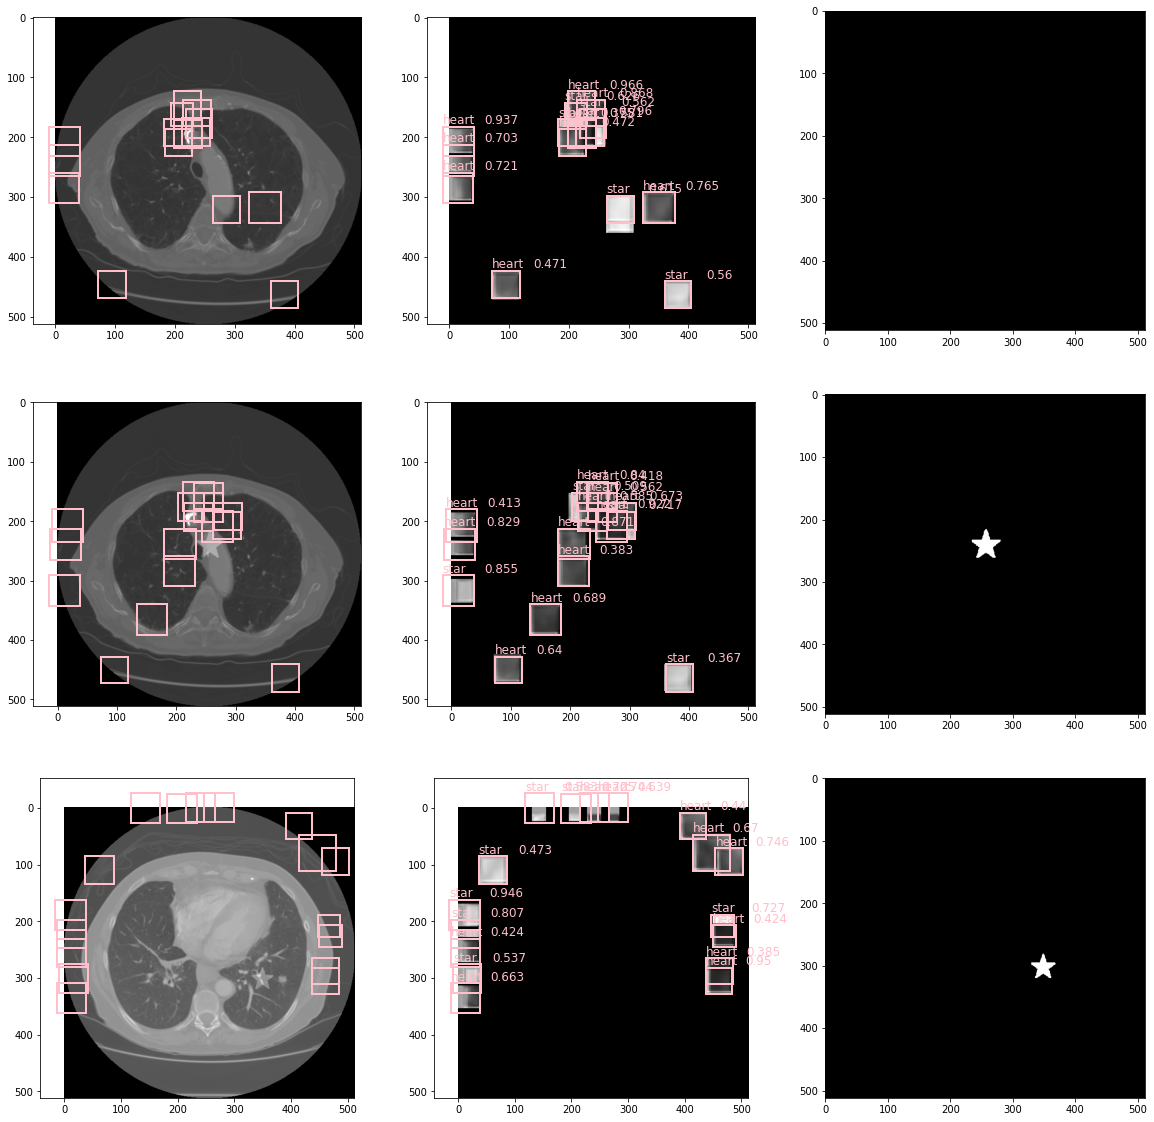

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)

## Training/Finetuning any part of the MaskRCNN

#### Backbone

In [8]:
batchgen_cnn=model_utils.batchgenerator_cnn(datafolder=IMAGEFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,numofdatas=FINETUNETRAINDATAS)
cnnmodel.fit(batchgen_cnn,epochs=1,steps_per_epoch=BATCHPEREPOCH)

1333/1333 [==============================] - 96s 70ms/step - loss: 0.7970 - binary_accuracy: 0.5052


#### RPN

In [9]:
model_utils.train_rpn(rpnmodell=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,proposalcount=PROPOSALCOUNT,\
                      datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS,numofdatas=FINETUNETRAINDATAS) 


c:\users\franciska\miniconda3\envs\tf_24\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\GIT\MaskRCNN\maskrcnn-from-scratch\utils.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_of_bboxes=np.array(batch_of_bboxes)


54 sec. 	 0 .epoch:	 loss(sum,c,bb):	 6.6030884 0.67834574 5.924743
56 sec. 	 1 .epoch:	 loss(sum,c,bb):	 6.5362973 0.65495 5.8813467
55 sec. 	 2 .epoch:	 loss(sum,c,bb):	 6.501703 0.63611317 5.86559


#### Classh-head, Box refinement

In [10]:
model_utils.train_classhead(classheadmodel=classheadmodel,rpnmodel=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,roisize=ROISIZE,\
                            numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 


D:\GIT\MaskRCNN\maskrcnn-from-scratch\utils.py:200: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_of_bboxes=np.array(batch_of_bboxes)


40 sec. 	 0 .epoch: 	 loss(c,bb):	 0.9015297 144.48499
40 sec. 	 1 .epoch: 	 loss(c,bb):	 0.8494842 144.33205
42 sec. 	 2 .epoch: 	 loss(c,bb):	 0.86117166 141.64627


#### Mask-head

In [11]:
model_utils.train_maskhead(maskheadmodel=maskheadmodel,rpnmodel=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,maskroisize=MASKROISIZE,\
                           numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 

65 sec. 	 0 .epoch: 	 loss:	 2268.6074
65 sec. 	 1 .epoch: 	 loss:	 1948.5325
65 sec. 	 2 .epoch: 	 loss:	 1903.0977


#### Training/Finetuning the complett MaskRCNN  

In [12]:
model_utils.train_complex(fmmodel=fmmodel,rpnmodel=rpnmodel,classheadmodel=classheadmodel,maskheadmodel=maskheadmodel,\
                          allanchors=ALLANCHORS,proposalcount=PROPOSALCOUNT, roisize=ROISIZE,maskroisize=MASKROISIZE,\
                          numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 

115 sec. 	 0 .epoch: 	 rpn loss: 4.2880745 	ch loss: 123.172005 	mask loss: 10391.852
113 sec. 	 1 .epoch: 	 rpn loss: 1.7084217 	ch loss: 81.16106 	mask loss: 2331.3086
113 sec. 	 2 .epoch: 	 rpn loss: 1.0027357 	ch loss: 47.18652 	mask loss: 1163.3036


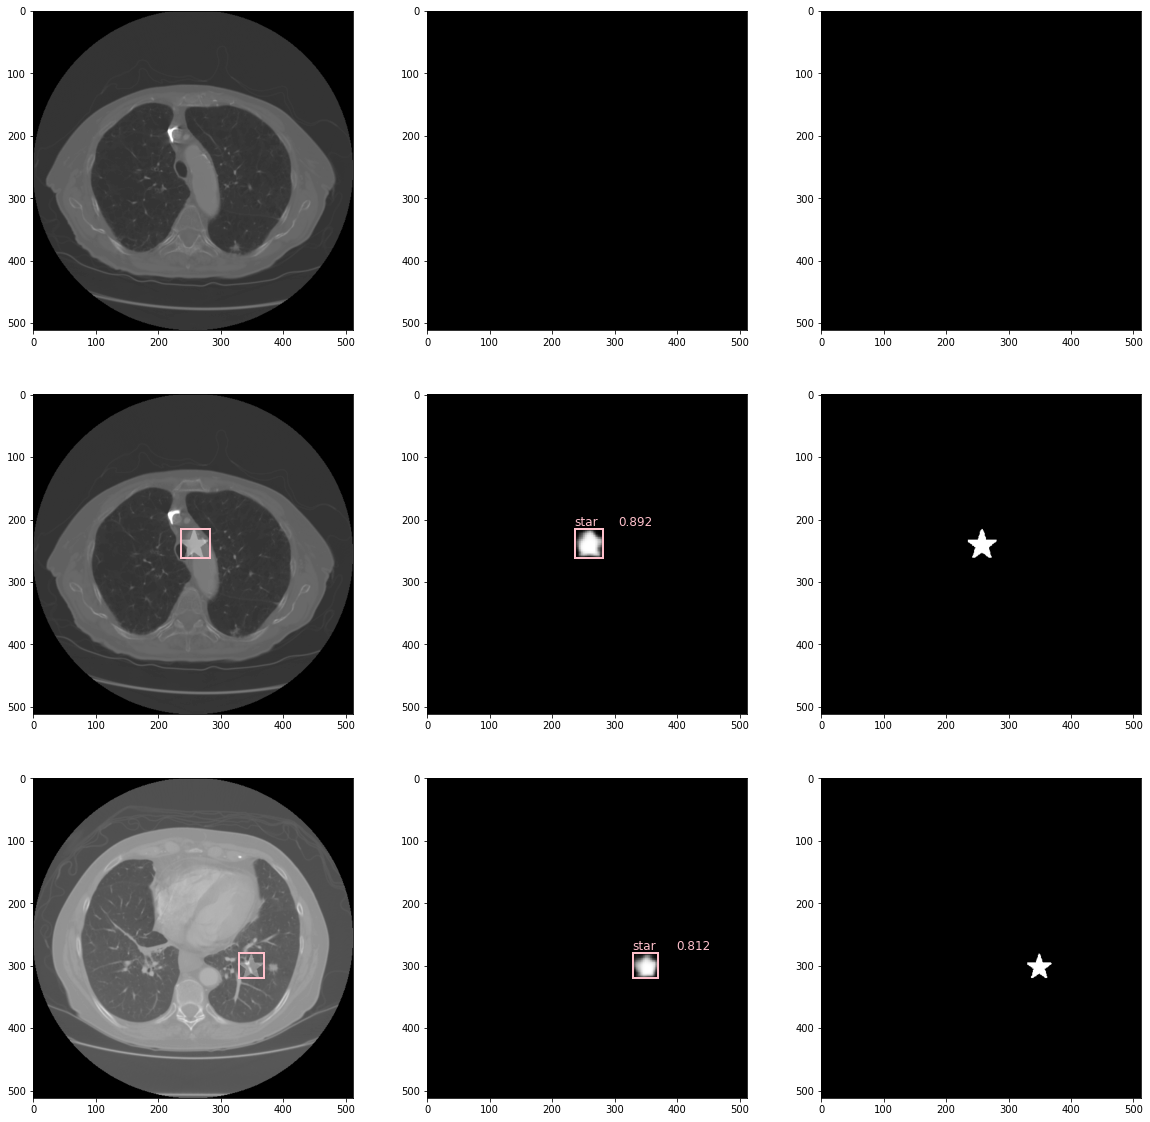

In [13]:
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)

### Saving models

In [ ]:
#suffix='_'+str(FINETUNETRAINDATAS)+'datas'+str(FINETUNEEPOCHS)+'epochs'

# cnnmodel.save('./saved_models/fullbackbone'+suffix+'.h5')
# fmmodel.save('./saved_models/fmmodel'+suffix+'.h5')
# rpnmodel.save('./saved_models/rpnmodel'+suffix+'.h5')
# classheadmodel.save('./saved_models/classheadmodel'+suffix+'.h5')
# maskheadmodel.save('./saved_models/maskheadmodel'+suffix+'.h5')

